In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
import tensorflow as tf

run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                input_tensor=tf.placeholder('float32', shape=(1,300,300,3)),
                mode='inference',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)
    
# Factor 1.5
print("{:,} --- {:,}".format(flops.total_float_ops/2, params.total_parameters))

710,825,060.0 --- 7,353,812


## Create new model with SSD weights

In [6]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [8]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'images_reduced'

# Ground truth
#train_labels_filename = preprocess_path + '/cic_train_reduced.csv'
train_labels_filename = preprocess_path + '/cic_train_val_reduced.csv'
val_labels_filename   = preprocess_path + '/cic_val_reduced.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 45/45 [00:00<00:00, 189.96it/s]
Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [9]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


## Remaining training parameters

In [10]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 400:
        return 0.001
    else:
        return 0.0001

In [10]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv2/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 156s 782ms/step - loss: 114.4196 - val_loss: 209.9463


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd

Number of images: 1025
Presicion: 0.013
Recall: 0.2125
F1 score: 0.0246
F1 score: 0.024566093217521782
Improve F1 score from -inf to 0.024566093217521782
Epoch 2/100
200/200 [==============================] - 124s 622ms/step - loss: 107.4678 - val_loss: 108.1601
Number of images: 1025
Presicion: 0.0124
Recall: 0.1449
F1 score: 0.0228
F1 score: 0.02278777923790583
Epoch 3/100
200/200 [==============================] - 138s 688ms/step - loss: 106.5236 - val_loss: 65.9522
Number of images: 1025
Presicion: 0.024
Recall: 0.2958
F1 score: 0.0445
F1 score: 0.04448215201265075
Improve F1 score from 0.024566093217521782 to 0.04448215201265075
Epoch 4/100
200/200 [==============================] - 135s 677ms/step - loss: 106.4440 - val_loss: 52.8834
Number of images: 1025
Presicion: 0.038
Recall: 0.3642
F1 score: 0.0688
F1 score: 0.06883696082051781
Improve F1 score from 0.04448215201265075 to 0.06883696082051781
Epoch 5/100
200/200 [==============================] - 137s 684ms/step - loss: 106.

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: invalid value encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: overflow encountered in subtract
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:278: RuntimeWarning: overflow encountered in subtract
  side_lengths = np.maximum(0, max_xy - min_xy + d)
/home/aldo/Documents/ssd/extra_files/helper.py:213: RuntimeWarning: overflow encountered in double_scalars
  b = [box[0], box[1], box[2], box[3], box[4] - box[2], box[5] - box[3]]
/home/aldo/Documents/ssd/extra_files/helper.py:229: RuntimeWarning: invalid value encountered in double_scalars
  xB = min(boxA[2] + boxA[0], boxB[2] + boxB[0])


Number of images: 1025
Presicion: 0.0061
Recall: 0.116
F1 score: 0.0117
F1 score: 0.011654898546744797
Epoch 6/100
200/200 [==============================] - 110s 549ms/step - loss: 106.6055 - val_loss: 34.8833
Number of images: 1025
Presicion: 0.0147
Recall: 0.2397
F1 score: 0.0277
F1 score: 0.027706179434847166
Epoch 7/100
200/200 [==============================] - 110s 550ms/step - loss: 108.2749 - val_loss: 31936.1385


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:381: RuntimeWarning: overflow encountered in add
  union_areas = boxes1_areas + boxes2_areas - intersection_areas


Number of images: 1025
Presicion: 0.0713
Recall: 0.395
F1 score: 0.1207
F1 score: 0.12074738773892746
Improve F1 score from 0.06883696082051781 to 0.12074738773892746
Epoch 8/100
200/200 [==============================] - 110s 552ms/step - loss: 106.7512 - val_loss: 74.9874
Number of images: 1025
Presicion: 0.0252
Recall: 0.2267
F1 score: 0.0454
F1 score: 0.04542664321969504
Epoch 9/100
200/200 [==============================] - 110s 551ms/step - loss: 106.5949 - val_loss: 27.6687
Number of images: 1025
Presicion: 0.0214
Recall: 0.2775
F1 score: 0.0397
F1 score: 0.039745308346142746
Epoch 10/100
200/200 [==============================] - 110s 549ms/step - loss: 106.5345 - val_loss: 35.8306
Number of images: 1025
Presicion: 0.0174
Recall: 0.1679
F1 score: 0.0315
F1 score: 0.03147434716931592
Epoch 11/100
200/200 [==============================] - 112s 558ms/step - loss: 106.5368 - val_loss: 30.3203
Number of images: 1025
Presicion: 0.0181
Recall: 0.1833
F1 score: 0.0329
F1 score: 0.0328

200/200 [==============================] - 110s 549ms/step - loss: 11.4484 - val_loss: 9.5096
Number of images: 1025
Presicion: 0.0621
Recall: 0.3998
F1 score: 0.1075
F1 score: 0.10749700277703628
Epoch 47/100
200/200 [==============================] - 111s 554ms/step - loss: 8.3184 - val_loss: 7.0449
Number of images: 1025
Presicion: 0.0698
Recall: 0.4122
F1 score: 0.1193
F1 score: 0.11931536846813862
Epoch 48/100
200/200 [==============================] - 136s 679ms/step - loss: 6.5529 - val_loss: 5.8420
Number of images: 1025
Presicion: 0.067
Recall: 0.4369
F1 score: 0.1163
F1 score: 0.1162532164802733
Epoch 49/100
200/200 [==============================] - 135s 676ms/step - loss: 5.7504 - val_loss: 5.3437
Number of images: 1025
Presicion: 0.0644
Recall: 0.4226
F1 score: 0.1117
F1 score: 0.11170508181211669
Epoch 50/100
200/200 [==============================] - 136s 679ms/step - loss: 5.3892 - val_loss: 5.1822
Number of images: 1025
Presicion: 0.069
Recall: 0.4216
F1 score: 0.1185


200/200 [==============================] - 111s 553ms/step - loss: 5.1692 - val_loss: 5.0346
Number of images: 1025
Presicion: 0.065
Recall: 0.4593
F1 score: 0.1139
F1 score: 0.11387373284270882
Epoch 86/100
200/200 [==============================] - 110s 550ms/step - loss: 5.1499 - val_loss: 5.0635
Number of images: 1025
Presicion: 0.0428
Recall: 0.435
F1 score: 0.0779
F1 score: 0.0779360998150109
Epoch 87/100
200/200 [==============================] - 110s 548ms/step - loss: 5.1726 - val_loss: 5.0324
Number of images: 1025
Presicion: 0.0533
Recall: 0.4569
F1 score: 0.0955
F1 score: 0.09548957693831961
Epoch 88/100
200/200 [==============================] - 110s 551ms/step - loss: 5.1555 - val_loss: 5.0482
Number of images: 1025
Presicion: 0.0572
Recall: 0.4653
F1 score: 0.1019
F1 score: 0.10193845051782342
Epoch 89/100
200/200 [==============================] - 108s 542ms/step - loss: 5.1430 - val_loss: 5.0291
Number of images: 1025
Presicion: 0.063
Recall: 0.4575
F1 score: 0.1107
F1

Number of images: 1025
Presicion: 0.0594
Recall: 0.5622
F1 score: 0.1074
F1 score: 0.10742161569803983
Epoch 62/100
200/200 [==============================] - 109s 543ms/step - loss: 4.1699 - val_loss: 4.1757
Number of images: 1025
Presicion: 0.0468
Recall: 0.5598
F1 score: 0.0863
F1 score: 0.08632739205188311
Epoch 63/100
200/200 [==============================] - 110s 550ms/step - loss: 4.1031 - val_loss: 4.1242
Number of images: 1025
Presicion: 0.056
Recall: 0.5664
F1 score: 0.1019
F1 score: 0.10194459710008986
Epoch 64/100
200/200 [==============================] - 112s 558ms/step - loss: 4.0750 - val_loss: 4.1550
Number of images: 1025
Presicion: 0.0476
Recall: 0.559
F1 score: 0.0878
F1 score: 0.08778035128438685
Epoch 65/100
200/200 [==============================] - 109s 547ms/step - loss: 4.0529 - val_loss: 4.1063
Number of images: 1025
Presicion: 0.0921
Recall: 0.5221
F1 score: 0.1566
F1 score: 0.1565603207491911
Epoch 66/100
200/200 [==============================] - 110s 552

Number of images: 1025
Presicion: 0.2724
Recall: 0.4466
F1 score: 0.3384
F1 score: 0.3383651448846033
Improve F1 score from 0.2964000544225637 to 0.3383651448846033
TRAINING MODEL WITH LEARNING RATE: 0.0001
Epoch 1/100
200/200 [==============================] - 125s 623ms/step - loss: 7.4579 - val_loss: 6.2454
Number of images: 1025
Presicion: 0.099
Recall: 0.3583
F1 score: 0.1552
F1 score: 0.15515707494167685
Improve F1 score from -inf to 0.15515707494167685
Epoch 2/100
200/200 [==============================] - 110s 549ms/step - loss: 6.3390 - val_loss: 5.9089
Number of images: 1025
Presicion: 0.111
Recall: 0.3514
F1 score: 0.1687
F1 score: 0.16865640084242667
Improve F1 score from 0.15515707494167685 to 0.16865640084242667
Epoch 3/100
200/200 [==============================] - 109s 546ms/step - loss: 5.9191 - val_loss: 5.6873
Number of images: 1025
Presicion: 0.1126
Recall: 0.3624
F1 score: 0.1719
F1 score: 0.1718583213491569
Improve F1 score from 0.16865640084242667 to 0.1718583213

Number of images: 1025
Presicion: 0.0642
Recall: 0.5318
F1 score: 0.1146
F1 score: 0.11462915049870609
Epoch 39/100
200/200 [==============================] - 110s 548ms/step - loss: 4.4305 - val_loss: 4.4957
Number of images: 1025
Presicion: 0.0592
Recall: 0.5281
F1 score: 0.1065
F1 score: 0.1064948328036034
Epoch 40/100
200/200 [==============================] - 109s 547ms/step - loss: 4.4013 - val_loss: 4.4579
Number of images: 1025
Presicion: 0.0572
Recall: 0.5358
F1 score: 0.1033
F1 score: 0.10328800567322437
Epoch 41/100
200/200 [==============================] - 111s 554ms/step - loss: 4.4196 - val_loss: 4.4299
Number of images: 1025
Presicion: 0.0584
Recall: 0.5295
F1 score: 0.1052
F1 score: 0.10517366223929406
Epoch 42/100
200/200 [==============================] - 110s 550ms/step - loss: 4.4459 - val_loss: 4.4679
Number of images: 1025
Presicion: 0.0563
Recall: 0.5395
F1 score: 0.1019
F1 score: 0.1019285653664774
Epoch 43/100
200/200 [==============================] - 110s 54

200/200 [==============================] - 110s 548ms/step - loss: 4.0871 - val_loss: 4.2731
Number of images: 1025
Presicion: 0.0619
Recall: 0.5493
F1 score: 0.1113
F1 score: 0.11132247548836775
Epoch 79/100
200/200 [==============================] - 110s 549ms/step - loss: 4.1319 - val_loss: 4.1615
Number of images: 1025
Presicion: 0.0525
Recall: 0.5647
F1 score: 0.0961
F1 score: 0.09613306695574761
Epoch 80/100
200/200 [==============================] - 111s 553ms/step - loss: 4.0890 - val_loss: 4.1192
Number of images: 1025
Presicion: 0.0637
Recall: 0.5602
F1 score: 0.1144
F1 score: 0.11435924555049082
Epoch 81/100
200/200 [==============================] - 110s 550ms/step - loss: 4.0703 - val_loss: 4.1189
Number of images: 1025
Presicion: 0.048
Recall: 0.5532
F1 score: 0.0884
F1 score: 0.08835462398309282
Epoch 82/100
200/200 [==============================] - 110s 549ms/step - loss: 4.0605 - val_loss: 4.0908
Number of images: 1025
Presicion: 0.0562
Recall: 0.5623
F1 score: 0.1022

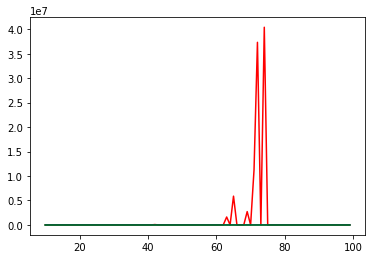

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

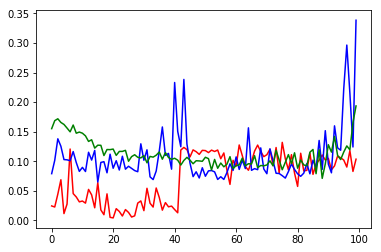

In [12]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [11]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/shufflenet_v2_factor_1.5.h5')
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/CIC/shufflenet_v2_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 500
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/CIC/shufflenet_v2_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/500

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 19s 1s/step - loss: 3.7538
Epoch 2/500

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 717ms/step - loss: 3.7112
Epoch 3/500

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 768ms/step - loss: 3.3867
Epoch 4/500

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 724ms/step - loss: 3.2710
Epoch 5/500

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 747ms/step - loss: 3.2539
Epoch 6/500

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 695ms/step - loss: 3.1619
Epoch 7/500

Epoch 00007: LearningRateScheduler setting learning 

15/15 [==============================] - 10s 698ms/step - loss: 2.1888
Epoch 109/500

Epoch 00109: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 707ms/step - loss: 2.2148
Epoch 110/500

Epoch 00110: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 684ms/step - loss: 2.1932
Epoch 111/500

Epoch 00111: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 713ms/step - loss: 2.1010
Epoch 112/500

Epoch 00112: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 2.1190
Epoch 113/500

Epoch 00113: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 685ms/step - loss: 2.0415
Epoch 114/500

Epoch 00114: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 712ms/step - loss: 2.1585
Epoch 115/5

15/15 [==============================] - 11s 727ms/step - loss: 2.1402
Epoch 163/500

Epoch 00163: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 697ms/step - loss: 1.9958
Epoch 164/500

Epoch 00164: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 691ms/step - loss: 1.9717
Epoch 165/500

Epoch 00165: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 727ms/step - loss: 2.0662
Epoch 166/500

Epoch 00166: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 711ms/step - loss: 2.0472
Epoch 167/500

Epoch 00167: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 754ms/step - loss: 2.0310
Epoch 168/500

Epoch 00168: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 707ms/step - loss: 1.9562
Epoch 169/5

15/15 [==============================] - 11s 709ms/step - loss: 1.8843
Epoch 217/500

Epoch 00217: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 716ms/step - loss: 1.9104
Epoch 218/500

Epoch 00218: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 712ms/step - loss: 1.9184
Epoch 219/500

Epoch 00219: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 735ms/step - loss: 1.9254
Epoch 220/500

Epoch 00220: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 1.8936
Epoch 221/500

Epoch 00221: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 694ms/step - loss: 1.9194
Epoch 222/500

Epoch 00222: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 692ms/step - loss: 1.9318
Epoch 223/5

15/15 [==============================] - 11s 711ms/step - loss: 1.7361
Epoch 271/500

Epoch 00271: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 705ms/step - loss: 1.9064
Epoch 272/500

Epoch 00272: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 1.8950
Epoch 273/500

Epoch 00273: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 694ms/step - loss: 1.8727
Epoch 274/500

Epoch 00274: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 717ms/step - loss: 1.7909
Epoch 275/500

Epoch 00275: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 1.8813
Epoch 276/500

Epoch 00276: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 692ms/step - loss: 1.7788
Epoch 277/5

15/15 [==============================] - 11s 716ms/step - loss: 1.8019
Epoch 325/500

Epoch 00325: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 1.7849
Epoch 326/500

Epoch 00326: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 718ms/step - loss: 1.7753
Epoch 327/500

Epoch 00327: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 690ms/step - loss: 1.7573
Epoch 328/500

Epoch 00328: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 699ms/step - loss: 1.6646
Epoch 329/500

Epoch 00329: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 703ms/step - loss: 1.8279
Epoch 330/500

Epoch 00330: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 1.7724
Epoch 331/5

15/15 [==============================] - 10s 692ms/step - loss: 1.7585
Epoch 379/500

Epoch 00379: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 693ms/step - loss: 1.6425
Epoch 380/500

Epoch 00380: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 711ms/step - loss: 1.6898
Epoch 381/500

Epoch 00381: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 718ms/step - loss: 1.7219
Epoch 382/500

Epoch 00382: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 689ms/step - loss: 1.7404
Epoch 383/500

Epoch 00383: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 719ms/step - loss: 1.6218
Epoch 384/500

Epoch 00384: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 708ms/step - loss: 1.6589
Epoch 385/5

15/15 [==============================] - 11s 713ms/step - loss: 1.4785
Epoch 485/500

Epoch 00485: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 684ms/step - loss: 1.5450
Epoch 486/500

Epoch 00486: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 712ms/step - loss: 1.6197
Epoch 487/500

Epoch 00487: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 718ms/step - loss: 1.5559
Epoch 488/500

Epoch 00488: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 722ms/step - loss: 1.5422
Epoch 489/500

Epoch 00489: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 728ms/step - loss: 1.5489
Epoch 490/500

Epoch 00490: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 692ms/step - loss: 1.4526
Epoch